1. **Definitions**:
    - Let $ s_t $ represent the image frame at time step $ t $.
    - Let $ s_{t+k} $ represent the image frame at time step $ t+k $, which is $ k $ time steps after $ s_t $.
2. **Problem Statement**:
    - **a)** Compute the geodesic distance between $ s_t $ and $ s_{t+k} $ in a suitable image embedding space.
    - **b)** Sample intermediate image frames that lie on the geodesic path between $ s_t $ and $ s_{t+k} $.

3. **Proposed Solution**:
    - **a)** Using a pretrained network's second-to-last layer as an embedding space, as embedding should meaningfully capture the content of the images due to the network's prior training on a potentially large and diverse dataset
    - **b)** Intermediate Frames:
        - i) interpolate and generate intermediate frames by gradient-based optimization w.r.t. target image in pixel space (Note: could be computationally intensive and might not always produce visually coherent transitions, especially if $ s_{\text{start}} $ and $ s_{\text{target}} $ are substantially different).
        - ii) Image morphing techniques
        - iii) Variational Autoencodes (VAE)
        - iv) Manifold Learning
        - v) fine-tune model and then do i)


4. **Mathematical Formulation**:
    - Let $ f $ be a neural network function that maps an image to a lower-dimensional embedding space, i.e., $ f: \mathcal{I} \rightarrow \mathbb{R}^d $ where $ \mathcal{I} $ is the space of images.
    - Define the geodesic distance $ d $ between  $s_t$  and $s_{t+k}$ as $ d(s_t, s_{t+k}) = \| f(s_t) - f(s_{t+k}) \| $, where $ \| \cdot \| $ denotes the Euclidean norm.
    - Intermediate frames  $s_{t+i}$  for $ i = 1, 2, \ldots, k-1 $ are generated by $ s_{t+i} = g(\theta_{t+i}) $, where $ \theta_{t+i} $ is a parameter vector obtained by interpolating between parameters representing $ s_t $ and $ s_{t+k} $ in the embedding space,
        - while $ d(s_t, s_{t+k}) > \epsilon $:
            - compute gradient of $ d(s_t, s_{t+k})$ w.r.t. input pixels 
            - update $s_t$ through gradient step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72
%matplotlib inline

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

from PIL import Image

import copy

import torch
torch.manual_seed(17)
import torch.nn as nn
# this notebook uses torchvision, which is an optional dependency.
# if this fails, install torchvision in your plenoptic environment 
# and restart the notebook kernel.
try:
    import torchvision
except ModuleNotFoundError:
    raise ModuleNotFoundError("optional dependency torchvision not found!"
                              " please install it in your plenoptic environment "
                              "and restart the notebook kernel")
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
#from torchvision.transforms import v2 as T
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

'2.3.1+cu121'

## Load test images


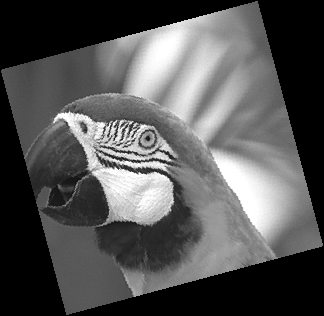

In [2]:
einstein = po.data.einstein()
# display the image of the tensor
# po.imshow(einstein)
# parrot = po.data.parrot()
# print(parrot.shape)

# load the image parrot.png
image_path = '../src/plenoptic/data/'
start_image_parrot = Image.open(image_path + 'parrot.png')
# image to tensor 
start_image_t_parrot = transforms.ToTensor()(start_image_parrot)

# define image transformations
target_image_t_parrot = TF.rotate(start_image_t_parrot, 15, expand=True)
target_image_parrot = transforms.ToPILImage()(target_image_t_parrot)
# display the rotated target image

start_image_parrot
target_image_parrot

In [3]:
IMG_WIDTH, IMG_HEIGHT = (224, 224)
angels = [0, 15, 30, 45, 60, 75, 90, 180, 360]


def transform_image(image, size=(IMG_WIDTH,IMG_HEIGHT), angle=30):
    """Resize and rotate the image.

    Args:
        image (PIL image): input image
        size (tuple): output image size
        angle (float): rotation angle

    Returns:    
        torch.tensor: transformed image
    """
    image = TF.resize(image, size)
    image = TF.rotate(image, angle)
    return transforms.ToTensor()(image)

In [4]:
s = TF.resize(start_image_t_parrot, size= (IMG_WIDTH, IMG_HEIGHT)) # resize to 224x224
t_30 = transform_image(start_image_parrot, angle=30)
assert (s == t_30).all() == False # should be unequal
(s == t_30).all()

tensor(False)

In [5]:
# Iterate over a list of angles and transform the images using transform_image function
# store the transformed images in a list
transformed_images = []
for angle in angels:
    transformed_images.append(transform_image(start_image_parrot, angle=angle))

len(transformed_images)

9

In [25]:
# assert if 0 degree rotated image is equal to the original image and 360 degree rotated image
# is equal to the original image

# Check if they are equal within a specified precision
absolute_tolerance = 1e-02 # becomes false for 1e-03
relative_tolerance = 1e-15
are_equal_s_t0 = torch.allclose(transformed_images[0], s, rtol=relative_tolerance, atol=absolute_tolerance)
print(f"Within an absolute tolereance of {absolute_tolerance}, \n and a relative tolerance of {relative_tolerance}, the original resized image and 0 degree rotated image are:\n {are_equal_s_t0}")
are_equal_s_t360 = torch.allclose(transformed_images[-1], s, rtol=relative_tolerance, atol=1e-02)
print(f"Within an absolute tolereance of {absolute_tolerance}, \n and a relative tolerance of {relative_tolerance}, the original resized image and 360 degree rotated image are:\n {are_equal_s_t360}")

Within an absolute tolereance of 0.01, 
 and a relative tolerance of 1e-15, the original resized image and 0 degree rotated image are:
 True
Within an absolute tolereance of 0.01, 
 and a relative tolerance of 1e-15, the original resized image and 360 degree rotated image are:
 False


In [7]:

def display_image_pairs(image_pairs):
    """
    Display pairs of images in rows with labels.

    Args:
    image_pairs (list of tuples): List of tuples where each tuple contains two images as tensors.
    """
    # Convert tensor to PIL image
    to_pil = transforms.ToPILImage()

    # Number of image pairs
    num_pairs = len(image_pairs)


    # Create a matplotlib figure
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))

    # Set the column titles
    fig.suptitle('Image Comparison', fontsize=16)
    fig.subplots_adjust(top=0.95)  # Adjust the top to make room for the title

    # Handle the case for a single pair differently to avoid indexing issues
    if num_pairs == 1:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes = [axes]  # Make axes a list of lists to handle it uniformly later
    else:
        fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))

    
    # Set column labels
    if num_pairs == 1:
        axes[0][0].set_title('Start Image', fontsize=14)
        axes[0][1].set_title('Target Image', fontsize=14)
    else:
        axes[0, 0].set_title('Start Image', fontsize=14)
        axes[0, 1].set_title('Target Image', fontsize=14)


        # Display each pair of images
    for i, (start_image, target_image) in enumerate(image_pairs):
        # Convert tensors to PIL images
        start_image_pil = to_pil(start_image)
        target_image_pil = to_pil(target_image)

        # Display the start image
        axes[i][0].imshow(start_image_pil)
        axes[i][0].axis('off')  # Turn off axis
        # Display the target image
        axes[i][1].imshow(target_image_pil)
        axes[i][1].axis('off')  # Turn off axis
        

    # Show the plot
    plt.show()

# List of pairs of images
image_pairs = [(s, t), (s, t_10)]
display_image_pairs(image_pairs)


NameError: name 't' is not defined

## Loading Pretrained Model

We download a pretrained model from  [ImageNet torchvision.models](https://pytorch.org/vision/stable/models.html). As ImageNet models have learned to detect animals, including parrots, it might be especially well suited for embedding different parrots in an interpreteble way, i.e, close to each other in embedding space.



In [ ]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network as used in the paper 
weights = VGG16_Weights.DEFAULT
vgg_model_original = vgg16(weights=weights)
vgg_model_original.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the base model and cutting of the final layer

In [ ]:
vgg_model_original.requires_grad_(False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Dropping the final layer
We don't want to classify our images, so let's drop the final layer by replacing it with an identity identity

In [ ]:
# copy the vgg model and remove the last layer
vgg_model = copy.deepcopy(vgg_model_original)
# replace the final layer with an identiy layer
#vgg_model.classifier[-1] = nn.Identity()
# drop the final three layers of the network
vgg_model.classifier = vgg_model.classifier[:-3] # we don't want the last three layers (relu, dropout, and fc)


In [ ]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Print the final layer of the VGG model
print("Final layer of VGG model:")
print(vgg_model.classifier[-1])
# print the shape of the final layer
print("Final layer shape:")
print(vgg_model.classifier[-1].out_features)

Final layer of VGG model:
Linear(in_features=4096, out_features=4096, bias=True)
Final layer shape:
4096


In [ ]:
def get_image_embeddings(image_pairs, model):
    """
    Processes a list of pairs of images through a pretrained model and returns their embeddings.

    Args:
        image_pairs (list of tuples): List of tuples where each tuple contains two images as tensors.
        model (torch.nn.Module): Pretrained model to use for generating embeddings.

    Returns:
        list of tuples: List of tuples where each tuple contains embeddings for the pair of images.
    """
    model.eval()  # Set the model to evaluation mode

    embeddings = []

    with torch.no_grad():  # Disable gradient calculation
        for img1, img2 in image_pairs:
            # Ensure the input tensors are on the same device as the model
            device = next(model.parameters()).device
            img1 = img1.to(device)
            img2 = img2.to(device)
            # add 2 more channels to each image
            img1 = img1.repeat(3, 1, 1)
            img2 = img2.repeat(3, 1, 1)

            # Get the embeddings for each image
            emb1 = model(img1.unsqueeze(0))  # Add batch dimension
            emb2 = model(img2.unsqueeze(0))  # Add batch dimension

            # Append the embeddings to the list
            embeddings.append((emb1, emb2))

    return embeddings

In [ ]:
# unpack embedding tuple into two lists
embeddings = get_image_embeddings(image_pairs=image_pairs, model=vgg_model)
emb_start, emb_target = zip(*embeddings)
emb_start[0]

tensor([[-1.0035, -1.1648,  0.4519,  ..., -0.0639, -0.6830, -1.5177]],
       device='cuda:0')

In [ ]:
# plot the two embeddings in a 2D space
def plot_embeddings(embeddings, title="Image Embeddings"):
    """
    Plots the embeddings in a 2D space.

    Args:
        embeddings (list of tuples): List of tuples where each tuple contains embeddings for a pair of images.
        title (str): Title of the plot (default: "Image Embeddings").
    """
    # Unpack the embeddings
    emb_start, emb_target = zip(*embeddings)

    # Convert the embeddings to numpy arrays
    emb_start = to_numpy(torch.cat(emb_start))
    emb_target = to_numpy(torch.cat(emb_target))

    # Create a scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(emb_start[:, 0], emb_start[:, 1], label='Start Image')
    plt.scatter(emb_target[:, 0], emb_target[:, 1], label='Target Image')
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

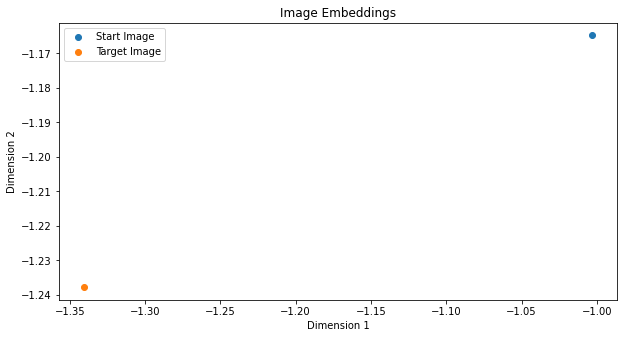

In [ ]:
plot_embeddings(embeddings, title="Image Embeddings")

In [ ]:
# compute the  distance between the two embeddings, default: Euclidean distance
def compute_distance(embeddings, p=2.0):
    """
    Computes the Euclidean distance between pairs of embeddings.

    Args:
        embeddings (list of tuples): List of tuples where each tuple contains embeddings for a pair of images.
        p (float): The norm to use for the distance calculation (default: 2.0).

    Returns:
        list of floats: List of distances between the embeddings.
    """
    distances = []

    for emb1, emb2 in embeddings:
        # Compute the Euclidean distance between the embeddings
        dist = torch.cdist(emb1, emb2, p=p)
        # Append the distance to the list
        distances.append(dist.item())

    return distances

In [ ]:
print(embeddings)
compute_distance(embeddings)


[(tensor([[-1.0035, -1.1648,  0.4519,  ..., -0.0639, -0.6830, -1.5177]],
       device='cuda:0'), tensor([[-1.3404, -1.2378, -0.7138,  ..., -0.1017,  0.0563, -0.3099]],
       device='cuda:0'))]


[35.72376251220703]

In [ ]:
embedding_pairs_test = [(emb_start[0], emb_start[0])]

compute_distance(embedding_pairs_test)

[0.0]

In [ ]:
# create a list of tuple of the start and target image
